In [8]:
import gym, gym_unbalanced_disk, time
import numpy as np
from stable_baselines3 import PPO, SAC
import matplotlib.pyplot as plt
from dataclasses import dataclass
from util_fun import make_filename

In [9]:
def normalise_angle(theta):
    return ((theta)%(2*np.pi))-np.pi

def compute_reward(self):
    q = normalise_angle(self.th)
    theta=self.th
    omega = self.omega
    u = self.u

    r=-100*q**2 
    return r

In [10]:
target_angle=np.pi
angle_reward = lambda self: ((np.cos(self.th-target_angle)+1.5)**2 - 0.25)
correctVelocity_reward = lambda self: 0.00125*(((np.cos(self.th)+1)/2)*(self.omega)**2)
voltage_penalty = lambda self: -0.01*((self.u)**2)
incorrectAngle_penalty = lambda self: -0.01*np.abs(self.th-target_angle)

reward_function = lambda self: angle_reward(self) + correctVelocity_reward(self) + voltage_penalty(self) + incorrectAngle_penalty(self)

In [11]:
# env = gym.make('unbalanced-disk-exp-v0', dt=0.025, umax=3.,reward_fun=reward_function)
# model = SAC('MlpPolicy', env, verbose=2, learning_starts=1000) #b)
model=SAC.load('SAC_working_save0.zip')

In [12]:
# model.learn(total_timesteps=60_000)
# model.save('SAC_irl_train')

In [13]:
env = gym.make('unbalanced-disk-exp-v0', dt=0.025, umax=3.,reward_fun=reward_function)  # gym.make('unbalanced-disk-v0', dt=0.025, umax=3.,reward_fun=compute_reward,noise_scale=1e-3) #  

connecting to experimental setup...done


In [14]:
render_sim = False
obs = env.reset()
u_list=[]
thetas=[]
omegas=[]
rewards=[]
try:
    for i in range(1000):
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if render_sim:
            env.render()
        u_list.append(action)
        thetas.append(obs[0])
        omegas.append(obs[1])
        rewards.append(reward)
        if render_sim:
            time.sleep(1/50)
finally:
    pass
    # env.close()

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

In [ ]:
env.close()

In [ ]:
def get_color(q):
    if abs(q) > 2 * np.pi / 3:  # lower 120
        c=0
    elif abs(q) > np.pi / 3:  # either side
        c=1
    else:  # top
        c=2
    return c

def compute_reward_sim(self):
    q = normalise_angle(self.th)
    r=compute_reward(self)
    c=get_color(q)
    return q, r, c

In [ ]:
@dataclass
class Data:
    th = None
    omega = None
    u = None

In [ ]:
u_list_exp=[float(x) for x in u_list]

In [ ]:
import json
results= {
    'u_list': u_list_exp,
    'omegas': omegas,
    'thetas': thetas,
    'rewards': rewards
}
filename=make_filename('SAC_irl_results3', '.json')
with open(filename, 'w') as f:
    json.dump(results,f)
print(filename)

In [ ]:
target_angle = np.pi # target set to be balanced on top

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
max_episode_steps=len(u_list)
# Plot theta
axs[0].plot([i*env.dt for i in range(max_episode_steps)], thetas, '.')
axs[0].set_title('Theta')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Angle (Rad)')
axs[0].axhline(y=target_angle, color='r', linestyle='-')
axs[0].axhline(y=-target_angle, color='r', linestyle='-')
axs[0].grid(True)

# Plot u
axs[1].plot([i*env.dt for i in range(max_episode_steps)], u_list, '.')
axs[1].set_title('u')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Input voltage (V)')
axs[1].grid(True)

# Plot omega
axs[2].plot([i*env.dt for i in range(max_episode_steps)], omegas, '.')
axs[2].set_title('Omega')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Angular velocity (rad/s)')
axs[2].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

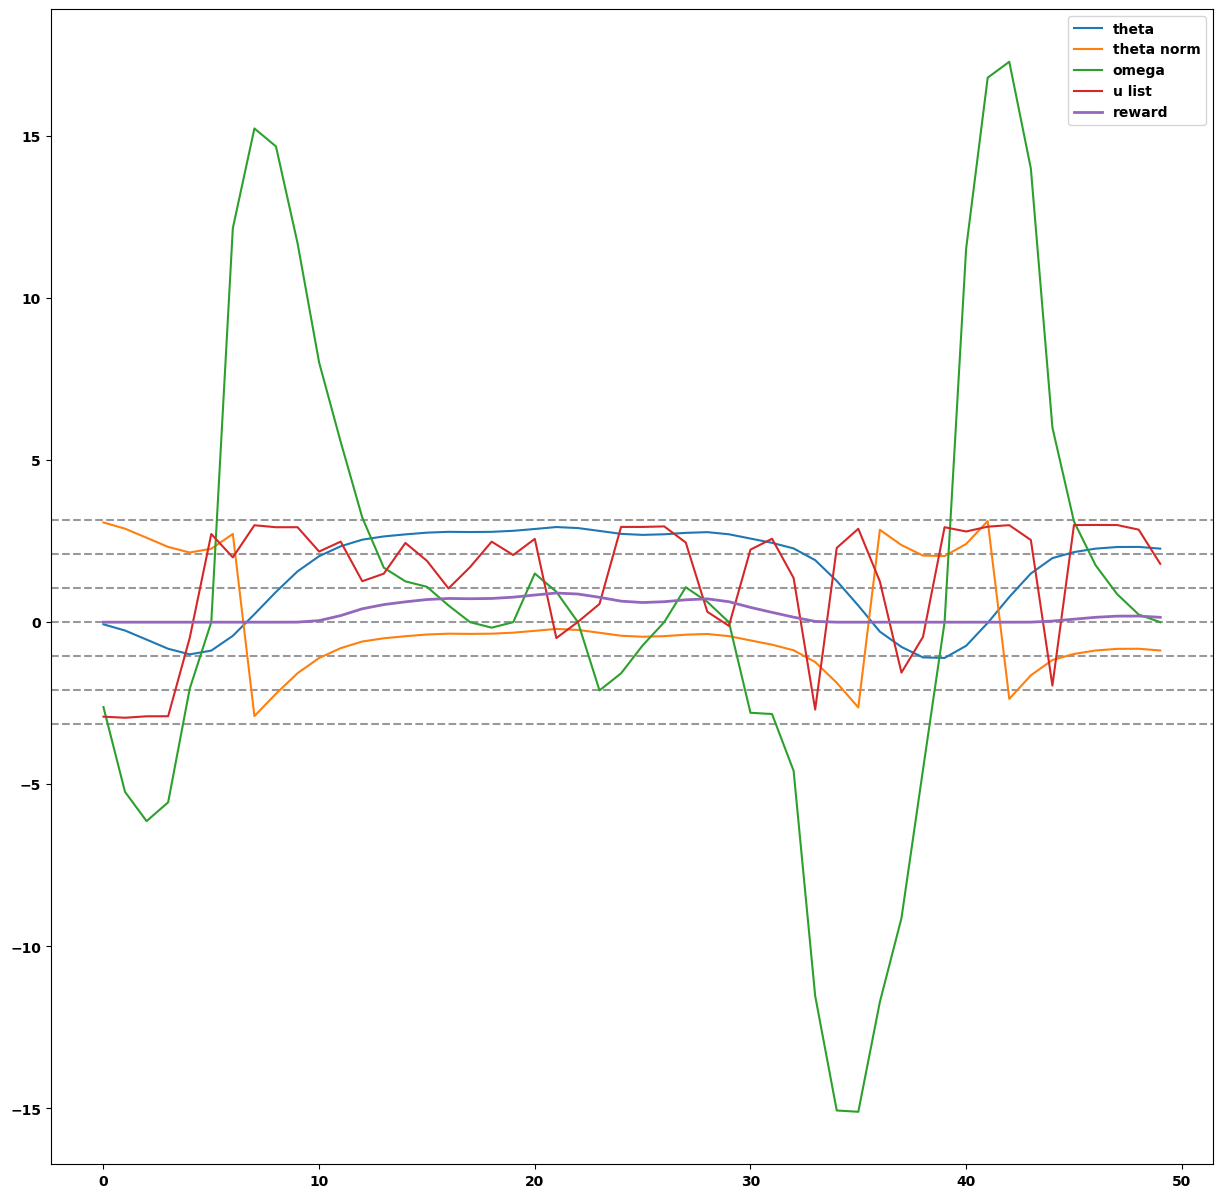

In [ ]:
rewards_sim=[]
colors=[]
thetas_norm=[]
colormap = np.array(['r', 'g', 'b'])
for i in range(len(u_list)):
    data=Data()
    data.th=thetas[i]
    data.omega=omegas[i]
    data.u=u_list[i]
    q, r,c = compute_reward_sim(data, )
    rewards_sim.append(r)
    colors.append(c)
    thetas_norm.append(q)

rewards_sim=np.array(rewards_sim)
rewards_sim=rewards_sim
colormap = np.array(['r', 'g', 'b'])


plot_start=0#np.argmax(rewards)
plot_end=plot_start+50

plt.figure(figsize=(15,15))
[plt.axhline(x, ls='--',c='black',alpha=0.4) for x in np.arange(-1,1.1,1/3)*np.pi]

plt.plot(thetas[plot_start:plot_end], label='theta')
plt.plot(thetas_norm[plot_start:plot_end], label='theta norm')
plt.plot(omegas[plot_start:plot_end], label='omega')
# plt.plot(np.array(omegas[:plot_end])**2, label='omega^2')
plt.plot(u_list[plot_start:plot_end], label='u list')
plt.plot(rewards[plot_start:plot_end], linewidth=2, label='reward')
# plt.scatter([*range(len(u_list[plot_start:plot_end]))], rewards_sim[plot_start:plot_end], ls='--', linewidth=2, label='reward sim', c=colormap[colors[plot_start:plot_end]])
plt.legend()
plt.show()